<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_StartingPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.5 MB/s eta 0:00:00


In [2]:
# utils
import os, sys, shap
import pandas as pd
import numpy as np
# catboost
import catboost
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# vis
import matplotlib.pyplot as plt

In [3]:
np.set_printoptions(precision=4)
print("NumPy version:", np.__version__)
print("CatBoost version:", catboost.__version__)

NumPy version: 1.26.4
CatBoost version: 1.2.5


In [4]:
from catboost.datasets import amazon
train_df, test_df = amazon()
print("train data frame shape: ", train_df.shape)
print("test data frame shape: ", test_df.shape)

train data frame shape:  (32769, 10)
test data frame shape:  (58921, 10)


In [5]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


In [8]:
for col in train_df.columns:
    print(col, train_df[col].nunique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [9]:
X = train_df.drop(["ACTION"], axis=1)
y = train_df.ACTION

In [10]:
cat_features = list(range(0, X.shape[1]))
cat_features

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
print("Labels: {}".format(set(y)))
print("Number of zeros and ones are {}, {}, respectively!".format(len(y)-sum(y), sum(y)))

Labels: {0, 1}
Number of zeros and ones are 1897, 30872, respectively!


In [12]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X, y, cat_features=cat_features, verbose=10)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 117ms	remaining: 11.5s
10:	learn: 0.1744186	total: 543ms	remaining: 4.4s
20:	learn: 0.1676119	total: 992ms	remaining: 3.73s
30:	learn: 0.1652446	total: 1.43s	remaining: 3.18s
40:	learn: 0.1633644	total: 1.9s	remaining: 2.73s
50:	learn: 0.1621892	total: 2.4s	remaining: 2.31s
60:	learn: 0.1609164	total: 2.93s	remaining: 1.87s
70:	learn: 0.1594572	total: 3.36s	remaining: 1.37s
80:	learn: 0.1585876	total: 3.92s	remaining: 920ms
90:	learn: 0.1573593	total: 4.47s	remaining: 442ms
99:	learn: 0.1566977	total: 5s	remaining: 0us


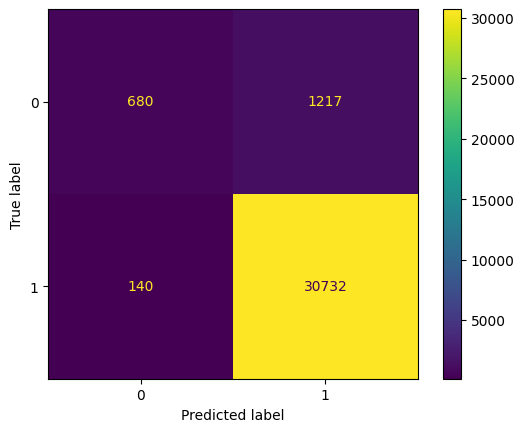

In [13]:
predictions = np.argmax(clf.predict_proba(X), axis=1)
cm = confusion_matrix(y_true=y, y_pred=predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=cat_features)
model = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function="Logloss")
model.fit(train_pool, eval_set=validation_pool, verbose=10)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 38.2ms	remaining: 3.79s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 510ms	remaining: 4.13s
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 786ms	remaining: 2.96s
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 1.21s	remaining: 2.7s
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 1.74s	remaining: 2.5s
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 2.19s	remaining: 2.1s
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 2.56s	remaining: 1.63s
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 2.96s	remaining: 1.21s
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 3.36s	remaining: 788ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 3.67s	remaining: 363ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 4.02s	remaining: 0us

bestTest = 0.1584908358
bestIteration

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=0)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=X_validation, label=y_validation, cat_features=cat_features)
model = CatBoostClassifier(iterations=100, learning_rate=0.1, custom_loss=["AUC", "Accuracy", "Logloss"],
                           train_dir="catboost_dir")
model.fit(train_pool, eval_set=validation_pool, verbose=10, plot=False)
print("Model is fitted: {}".format(model.is_fitted()))
print("Model parameters: {}".format(model.get_params()))
print("Tree count:" + str(model.tree_count_))
catboost.MetricVisualizer(["catboost_dir"]).start()

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 38.8ms	remaining: 3.84s
10:	learn: 0.3023734	test: 0.3000875	best: 0.3000875 (10)	total: 376ms	remaining: 3.04s
20:	learn: 0.2224740	test: 0.2182753	best: 0.2182753 (20)	total: 683ms	remaining: 2.57s
30:	learn: 0.1915694	test: 0.1843315	best: 0.1843315 (30)	total: 1.05s	remaining: 2.35s
40:	learn: 0.1810866	test: 0.1723486	best: 0.1723486 (40)	total: 1.47s	remaining: 2.12s
50:	learn: 0.1766195	test: 0.1650760	best: 0.1650760 (50)	total: 1.83s	remaining: 1.76s
60:	learn: 0.1743201	test: 0.1620310	best: 0.1620310 (60)	total: 2.25s	remaining: 1.44s
70:	learn: 0.1727259	test: 0.1604053	best: 0.1604053 (70)	total: 2.74s	remaining: 1.12s
80:	learn: 0.1717055	test: 0.1592850	best: 0.1592850 (80)	total: 3.18s	remaining: 746ms
90:	learn: 0.1709790	test: 0.1587529	best: 0.1587529 (90)	total: 3.51s	remaining: 347ms
99:	learn: 0.1704454	test: 0.1585780	best: 0.1584908 (96)	total: 3.8s	remaining: 0us

bestTest = 0.1584908358
bestIterati

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
params = {
    "loss_function": "Logloss",
    "iterations": 80,
    "custom_loss": "AUC",
    "learning_rate": 0.1
}
cv_data = cv(params=params, pool=train_pool, fold_count=5,
             shuffle=True, partition_random_seed=0, plot=True, verbose=20, stratified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5812867	test: 0.5812871	best: 0.5812871 (0)	total: 55.3ms	remaining: 4.37s
20:	learn: 0.1932578	test: 0.1849005	best: 0.1849005 (20)	total: 1.42s	remaining: 3.99s
40:	learn: 0.1760028	test: 0.1652442	best: 0.1652442 (40)	total: 4.13s	remaining: 3.93s
60:	learn: 0.1709795	test: 0.1622999	best: 0.1622999 (60)	total: 5.87s	remaining: 1.83s
79:	learn: 0.1687357	test: 0.1613221	best: 0.1612996 (78)	total: 7.28s	remaining: 0us

bestTest = 0.1612996284
bestIteration = 78

Training on fold [1/5]
0:	learn: 0.5812726	test: 0.5812835	best: 0.5812835 (0)	total: 29.2ms	remaining: 2.31s
20:	learn: 0.1924537	test: 0.1863979	best: 0.1863979 (20)	total: 1.06s	remaining: 2.99s
40:	learn: 0.1761818	test: 0.1680655	best: 0.1680655 (40)	total: 2.59s	remaining: 2.47s
60:	learn: 0.1710659	test: 0.1634331	best: 0.1634331 (60)	total: 3.79s	remaining: 1.18s
79:	learn: 0.1682807	test: 0.1617425	best: 0.1617425 (79)	total: 4.93s	remaining: 0us

bestTest = 0.1617424602
bestIterat

In [17]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.581285,0.000002,0.581281,0.000007,0.496175,0.014042
1,1,0.496233,0.000040,0.496221,0.000035,0.519188,0.016686
2,2,0.430985,0.000034,0.430972,0.000030,0.519188,0.016686
3,3,0.381694,0.000227,0.381684,0.000312,0.532236,0.022482
4,4,0.342926,0.000777,0.342961,0.000705,0.580106,0.031891


In [18]:
best_value = np.min(cv_data["test-Logloss-mean"])
best_itr = np.argmin(cv_data["test-Logloss-mean"])
print("Best validation logloss: {:.4f}±{:.4f} on step {}".format(best_value, cv_data["test-Logloss-std"][best_itr], best_itr))

Best validation logloss: 0.1623±0.0027 on step 79


In [19]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.5]
}
clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6854053	total: 7.99ms	remaining: 152ms
19:	learn: 0.5630952	total: 94.1ms	remaining: 0us
0:	learn: 0.6853954	total: 6.99ms	remaining: 133ms
19:	learn: 0.5631574	total: 114ms	remaining: 0us
0:	learn: 0.6192124	total: 7.85ms	remaining: 149ms
19:	learn: 0.2347140	total: 108ms	remaining: 0us
0:	learn: 0.6191226	total: 6.9ms	remaining: 131ms
19:	learn: 0.2350162	total: 118ms	remaining: 0us
0:	learn: 0.3980546	total: 7.86ms	remaining: 149ms
19:	learn: 0.1824618	total: 156ms	remaining: 0us
0:	learn: 0.3977985	total: 6.97ms	remaining: 132ms
19:	learn: 0.1775158	total: 178ms	remaining: 0us
0:	learn: 0.3971379	total: 16.4ms	remaining: 312ms
19:	learn: 0.1717590	total: 317ms	remaining: 0us


{'iterations': 20,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'learning_rate': 0.5}

In [20]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20,
    eval_metric="AUC"
)
model.fit(train_pool, eval_set=validation_pool, verbose=True, plot=True)
print(model.tree_count_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5509439	best: 0.5509439 (0)	total: 48.1ms	remaining: 9.57s
1:	test: 0.6760414	best: 0.6760414 (1)	total: 107ms	remaining: 10.6s
2:	test: 0.8346361	best: 0.8346361 (2)	total: 162ms	remaining: 10.6s
3:	test: 0.8450107	best: 0.8450107 (3)	total: 212ms	remaining: 10.4s
4:	test: 0.8495952	best: 0.8495952 (4)	total: 287ms	remaining: 11.2s
5:	test: 0.8711362	best: 0.8711362 (5)	total: 371ms	remaining: 12s
6:	test: 0.8742206	best: 0.8742206 (6)	total: 444ms	remaining: 12.2s
7:	test: 0.8821079	best: 0.8821079 (7)	total: 498ms	remaining: 12s
8:	test: 0.8823957	best: 0.8823957 (8)	total: 554ms	remaining: 11.8s
9:	test: 0.8849074	best: 0.8849074 (9)	total: 632ms	remaining: 12s
10:	test: 0.8847697	best: 0.8849074 (9)	total: 683ms	remaining: 11.7s
11:	test: 0.8848115	best: 0.8849074 (9)	total: 758ms	remaining: 11.9s
12:	test: 0.8883924	best: 0.8883924 (12)	total: 830ms	remaining: 11.9s
13:	test: 0.8895193	best: 0.8895193 (13)	total: 904ms	remaining: 12s
14:	test: 0.8930982	best: 0.8930982

In [21]:
clf = CatBoostClassifier(iterations=200, learning_rate=0.03)
clf.fit(train_pool, verbose=50)
print("prediction:\n", clf.predict(X_validation))
print("prediction probabilities:\n", clf.predict_proba(X_validation))

0:	learn: 0.6569432	total: 44.2ms	remaining: 8.8s
50:	learn: 0.1937127	total: 2.01s	remaining: 5.88s
100:	learn: 0.1652233	total: 4.42s	remaining: 4.33s
150:	learn: 0.1587891	total: 7.22s	remaining: 2.34s
199:	learn: 0.1551770	total: 11s	remaining: 0us
prediction:
 [1 1 1 ... 1 1 1]
prediction probabilities:
 [[0.0291 0.9709]
 [0.0204 0.9796]
 [0.0101 0.9899]
 ...
 [0.0281 0.9719]
 [0.046  0.954 ]
 [0.0244 0.9756]]


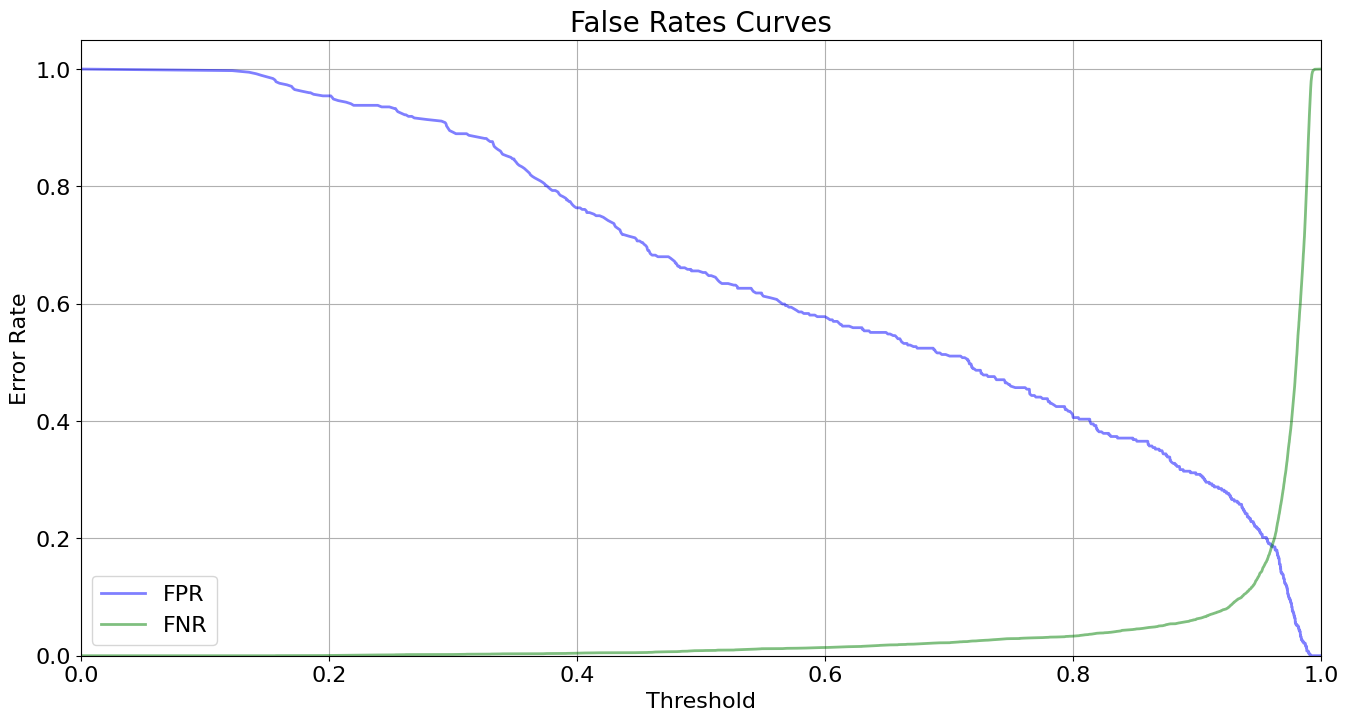

In [22]:
curve = get_roc_curve(clf, validation_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)
plt.figure(figsize=(16,8))
style = {"alpha": 0.5, "lw": 2}
plt.plot(thresholds, fpr, color="blue", label="FPR", **style)
plt.plot(thresholds, fnr, color="green", label="FNR", **style)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Error Rate", fontsize=16)
plt.title("False Rates Curves", fontsize=20)
plt.legend(loc="lower left", fontsize=16)

In [23]:
print(select_threshold(clf, validation_pool, FNR=0.01))
print(select_threshold(clf, validation_pool, FPR=0.01))

0.5265607057995692
0.9887115638534019


In [24]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=["Logloss", "AUC"],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)
print("AUC values:\n{}".format(np.array(metrics["AUC"])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC values:
[0.5509 0.676  0.8346 0.845  0.8496 0.8711 0.8742 0.8821 0.8824 0.8849
 0.8848 0.8848 0.8884 0.8895 0.8931 0.8924 0.8946 0.8947 0.8955 0.8953
 0.8949 0.8946 0.8945 0.8944 0.8949 0.895  0.8948 0.8951 0.8951 0.8953
 0.8956 0.8962 0.8963 0.8966 0.8965 0.8953 0.8954 0.8959 0.896  0.8961
 0.8966 0.8971 0.897  0.8974 0.8986 0.8988 0.8989 0.898  0.8988 0.8992
 0.9002]


In [25]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 22.361227417758467],
       ['MGR_ID', 17.454369620873386],
       ['ROLE_ROLLUP_2', 16.313797697833472],
       ['ROLE_DEPTNAME', 11.164726089768163],
       ['ROLE_FAMILY_DESC', 9.784409477444612],
       ['ROLE_FAMILY', 6.889658353969687],
       ['ROLE_CODE', 6.594075443049673],
       ['ROLE_TITLE', 5.202625227306577],
       ['ROLE_ROLLUP_1', 4.235110671995955]], dtype=object)

In [26]:
np.array(model.get_feature_importance(train_pool, "LossFunctionChange", prettified=True))

array([['MGR_ID', 0.024928016144570294],
       ['RESOURCE', 0.02028735137062876],
       ['ROLE_FAMILY_DESC', 0.008892508926041853],
       ['ROLE_CODE', 0.00812936576333172],
       ['ROLE_DEPTNAME', 0.004839349100519041],
       ['ROLE_ROLLUP_2', 0.0044090575886355406],
       ['ROLE_TITLE', 0.0008321564785479605],
       ['ROLE_ROLLUP_1', -0.00022686749740492376],
       ['ROLE_FAMILY', -0.0005289501957344827]], dtype=object)

In [27]:
print(model.predict_proba([X.iloc[1,:]]))
print(model.predict_proba([X.iloc[87,:]]))

[[0.0062 0.9938]]
[[0.0071 0.9929]]


In [28]:
shap_values = model.get_feature_importance(validation_pool, "ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(6554, 9)


In [29]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_validation.iloc[1,:])

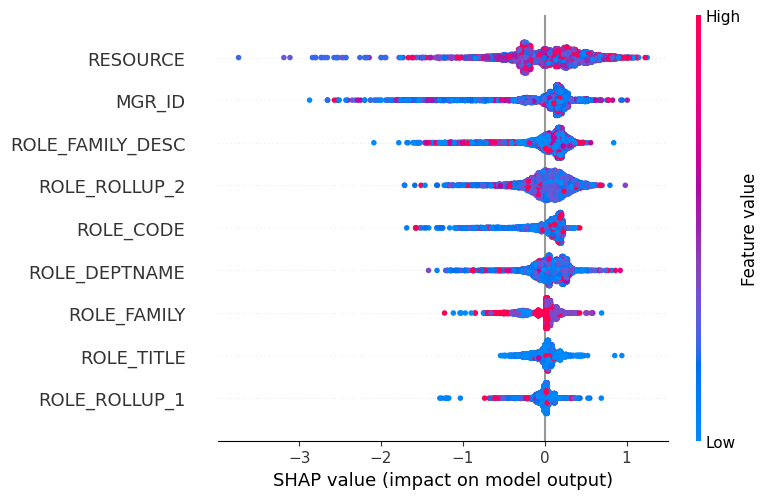

In [30]:
shap.summary_plot(shap_values, X_validation)

In [31]:
tuned_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)
tuned_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
fast_model = CatBoostClassifier(
    boosting_type="Plain",
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.05,
    bootstrap_type="Bernoulli",
    subsample=0.5
)
fast_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
small_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))